In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Conv2DTranspose, AveragePooling2D, Add, Reshape
from scipy.interpolate import RectBivariateSpline
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Boundary import Boundary1D
from MergeWithAttention import MergeWithAttention2
from Upsample import Upsample
from collections.abc import Iterable
import itertools, h5py
from multiprocessing import Pool as ThreadPool
from Lp_integral_norm import Lp_integral_norm
opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
conf = tf.ConfigProto(gpu_options=opts)
tfe.enable_eager_execution(config=conf)
tf.keras.backend.set_floatx('float64')

In [67]:
ntest = 64
h = 0.05
folder = 'dataset_' + str(ntest)
boundary_top = Boundary1D('Dirichlet', [(0,ntest*h),(ntest*h,ntest*h)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_right = Boundary1D('Dirichlet', [(ntest*h,ntest*h),(ntest*h,0)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_bottom = Boundary1D('Dirichlet', [(ntest*h,0),(0,0)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_left = Boundary1D('Dirichlet', [(0,0),(0,ntest*h)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)

In [3]:
for i in range(0,5):
    with h5py.File(folder + '/range_-1_1/dataset' + str(i) + '_-11.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            train_data = train_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            train_data = tf.data.Dataset.from_tensor_slices((F,soln))

In [4]:
for i in range(5,6):
    with h5py.File(folder + '/range_-1_1/dataset' + str(i) + '_-11.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            valid_data = valid_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            valid_data = tf.data.Dataset.from_tensor_slices((F,soln))

In [ ]:
# with h5py.File('dataset' + str(8) + '.h5', 'r') as hf:
#         F_valid = np.array(hf.get('F'), dtype = np.float64)
#         soln_valid = np.array(hf.get('soln'), dtype = np.float64)

In [5]:
shuffle_size = 100000
batch_size = 200
train_data = train_data.shuffle(shuffle_size).batch(batch_size)
valid_data = valid_data.shuffle(shuffle_size).batch(batch_size)
del F, soln

In [ ]:
#stable model
input_0 = Input(shape=(1,ntest,ntest,))
conv_1_0 = Conv2D(filters = 5, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(input_0)

conv_2_0 = Conv2D(filters = 16, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(conv_1_0)
pool_2_0 = AveragePooling2D(data_format = 'channels_first')(conv_2_0)
pool_2_1 = AveragePooling2D(data_format = 'channels_first')(pool_2_0)
pool_2_2 = AveragePooling2D(data_format = 'channels_first')(pool_2_1)
pool_2_3 = AveragePooling2D(data_format = 'channels_first')(pool_2_2)
pool_2_4 = AveragePooling2D(data_format = 'channels_first')(pool_2_3)
pool_2_5 = AveragePooling2D(data_format = 'channels_first')(pool_2_4)
pool_2_6 = AveragePooling2D(data_format = 'channels_first')(pool_2_5)

conv_3_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_2_0)
conv_3_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_0)
conv_3_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_1)
conv_3_3 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_2)
conv_3_4 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_3)
conv_3_5 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_4)
conv_3_6 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_5)
#conv_3_7 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_6)

upsample_3_1 = Upsample(resize_method=tf.image.ResizeMethod.BICUBIC)(conv_3_1)
upsample_3_2 = Upsample(4, resize_method=tf.image.ResizeMethod.BICUBIC)(conv_3_2)
upsample_3_3 = Upsample(8, resize_method=tf.image.ResizeMethod.BICUBIC)(conv_3_3)
upsample_3_4 = Upsample(16, resize_method=tf.image.ResizeMethod.BICUBIC)(conv_3_4)
upsample_3_5 = Upsample(32, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_5)
upsample_3_6 = Upsample(64, resize_method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)(conv_3_6)
#upsample_3_7 = Upsample(128, resize_method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)(conv_3_7)

conv_4_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_3_0)
conv_4_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_1)
conv_4_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_2)
conv_4_3 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_3)
conv_4_4 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_4)
conv_4_5 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_5)
#conv_4_6 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_6)

#merge_4_0 = MergeWithAttention2()([conv_4_0, conv_4_1, conv_4_2, conv_4_3, conv_4_4, conv_4_5, conv_4_6, upsample_3_7])
merge_4_0 = MergeWithAttention2()([conv_4_0, conv_4_1, conv_4_2, conv_4_3, conv_4_4, conv_4_5, upsample_3_6])#, upsample_3_7])

conv_5_0 = Conv2D(filters = 16, kernel_size = 3, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(merge_4_0)

conv_5_1 = Conv2D(filters = 5, kernel_size = 3, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_5_0)
#final_activation = tf.keras.layers.PReLU()(conv_5_1)
conv_6_0 = Conv2D(filters = 1, kernel_size = 3, activation='linear', data_format = 'channels_first', padding='same')(conv_5_1)#(final_activation)

a = Model(input_0, conv_6_0)
#a.load_weights(folder + '/model_stable.h5') - for [0,1] - 1.3% mae
#a.load_weights(folder + '/model_stable_-11.h5') - 4% mae

In [37]:
#how to train this - start with lr = 1e-2, switch to lr = 1e-4/1e-5 later on, keep mse component to 1e+1. use large no. of steps per epoch.
a.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-4), loss = Lp_integral_norm((ntest,ntest), [0,ntest*h,0,ntest*h], n_quadpts=20, quadpts_randomization=2, p=2, mse_component_weight = 1e+1), metrics = ['mse','mae'])
#a.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-2), loss = 'mse', metrics = ['mae'])

a.summary()

NameError: name 'a' is not defined

In [ ]:
while True:
    a.fit(train_data, steps_per_epoch=50, epochs=20, validation_data=valid_data, validation_steps=2)

In [ ]:
a.save_weights(folder + '/model_stable_-11.h5')

In [6]:
#testing model
input_0 = Input(shape=(1,ntest,ntest,))
conv_1_0 = Conv2D(filters = 5, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(input_0)

conv_2_0 = Conv2D(filters = 16, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(conv_1_0)
pool_2_0 = AveragePooling2D(data_format = 'channels_first')(conv_2_0)
pool_2_1 = AveragePooling2D(data_format = 'channels_first')(pool_2_0)
pool_2_2 = AveragePooling2D(data_format = 'channels_first')(pool_2_1)
pool_2_3 = AveragePooling2D(data_format = 'channels_first')(pool_2_2)
pool_2_4 = AveragePooling2D(data_format = 'channels_first')(pool_2_3)
pool_2_5 = AveragePooling2D(data_format = 'channels_first')(pool_2_4)
pool_2_6 = AveragePooling2D(data_format = 'channels_first')(pool_2_5)

conv_3_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_2_0)
conv_3_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_0)
conv_3_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_1)
conv_3_3 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_2)
conv_3_4 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_3)
conv_3_5 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_4)
conv_3_6 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_5)
#conv_3_7 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_6)

upsample_3_1 = Upsample(2, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_1)
upsample_3_2 = Upsample(4, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_2)
upsample_3_3 = Upsample(8, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_3)
upsample_3_4 = Upsample(16, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_4)
upsample_3_5 = Upsample(32, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_5)
upsample_3_6 = Upsample(64, resize_method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)(conv_3_6)


conv_4_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_3_0)
conv_4_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_1)
conv_4_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_2)
conv_4_3 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_3)
conv_4_4 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_4)
conv_4_5 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_5)
#conv_4_6 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_6)


#merge_4_0 = MergeWithAttention2()([conv_4_0, conv_4_1, conv_4_2, conv_4_3, conv_4_4, conv_4_5, conv_4_6, upsample_3_7])
merge_4_0 = MergeWithAttention2()([conv_4_0, conv_4_1, conv_4_2, conv_4_3, conv_4_4, conv_4_5, upsample_3_6])#, upsample_3_7])

conv_5_0 = Conv2D(filters = 16, kernel_size = 3, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(merge_4_0)

conv_5_1 = Conv2D(filters = 5, kernel_size = 3, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_5_0)
#final_activation = tf.keras.layers.PReLU()(conv_5_1)
conv_6_0 = Conv2D(filters = 1, kernel_size = 3, activation='linear', data_format = 'channels_first', padding='same')(conv_5_1)

conv_7_0 = Conv2D(filters = 1, kernel_size = 1, activation=tf.nn.tanh, data_format = 'channels_first', padding = 'same')(conv_5_1)
prelu_7_0 = tf.keras.layers.PReLU()(conv_6_0)
merge_7_0 = tf.keras.layers.Multiply()([conv_7_0, prelu_7_0])

b = Model(input_0, merge_7_0)

In [62]:
b.compile(optimizer = tf.train.AdamOptimizer(learning_rate=5e-6), loss = Lp_integral_norm((64,64), domain = [0,ntest*h,0,ntest*h], n_quadpts = 20, quadpts_randomization = 2, mse_component_weight = 1e+1), metrics = ['mse','mae'])
#b.summary()

In [ ]:
from IPython.display import clear_output
while True:
    b.fit(train_data, steps_per_epoch=50, epochs=20, validation_data=valid_data, validation_steps=3)
    clear_output(wait = True)

In [59]:
b.save_weights(folder + '/model_test_prelutanh_-11.h5')

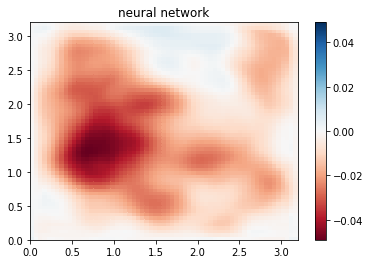

In [50]:
#plotting
#p = valid_data.make_one_shot_iterator().get_next()
#p_r = np.random.randint(0,batch_size)
y, x = np.meshgrid(np.linspace(0, ntest*h, ntest), np.linspace(0, ntest*h, ntest))
z = b.predict(tf.expand_dims(p[0][p_r,...], axis=0))[0,0,...]
#z = p[1][p_r,0,...]
#z = generate_random_RHS(10, n_controlpts=10, n_outputpts=64)[4,:,:]
#z = b.predict(tf.expand_dims(p[0][p_r,...], axis=0))[0,0,...] - p[1][p_r,0,...]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('neural network')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [46]:
#mean % error
tf.reduce_mean(tf.abs(b.predict(p[0][...]) - p[1][...]))/tf.reduce_mean(tf.abs(p[1][...]))

<tf.Tensor: id=28314835, shape=(), dtype=float64, numpy=0.046065522199080174>

In [ ]:
#dummy model to test memory/compute time scaling when doing inference
ntest2 = 160
input_0 = Input(shape=(1,ntest2,ntest2,))
conv_1_0 = Conv2D(filters = 5, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(input_0)

conv_2_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(conv_1_0)
pool_2_0 = AveragePooling2D(data_format = 'channels_first')(conv_2_0)
pool_2_1 = AveragePooling2D(data_format = 'channels_first')(pool_2_0)
pool_2_2 = AveragePooling2D(data_format = 'channels_first')(pool_2_1)
pool_2_3 = AveragePooling2D(pool_size=(4,4), data_format = 'channels_first')(pool_2_2)

conv_3_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_2_0)
conv_3_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_0)
conv_3_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_1)
conv_3_3 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_2)
conv_3_4 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_3)
upsample_3_1 = Upsample()(conv_3_1)
upsample_3_2 = Upsample(4)(conv_3_2)
upsample_3_3 = Upsample(8)(conv_3_3)
upsample_3_4 = Upsample(32)(conv_3_4)
merge_3_0 = Add()([conv_3_0, upsample_3_1, upsample_3_2, upsample_3_3, upsample_3_4])

conv_4_0 = Conv2D(filters = 8, kernel_size = 1, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(merge_3_0)

conv_5_0 = Conv2D(filters = 1, kernel_size = 1, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_4_0)
final_activation = tf.keras.layers.PReLU()(conv_5_0)
c = Model(input_0, final_activation)

In [ ]:
#neural network computation time
import time
g = tf.random.uniform((1,1,ntest2,ntest2),dtype=tf.float64)
t0 = time.time()
c.predict_on_batch(g)
t1 = time.time()
print(t1-t0)

In [72]:
#Cholesky decomposition computation time (time taken to do the decomposition not incl.)
import time
f = np.random.rand(1,1,ntest,ntest)
lhs = tf.constant(poisson_matrix(ntest,ntest), dtype=tf.float64)
lhs_chol = tf.expand_dims(tf.linalg.cholesky(lhs), axis=0)
boundaries = {'top': boundary_top.RHS_evaluate(np.linspace(boundary_top.t.min(),boundary_top.t.max(),ntest)), 'right': boundary_right.RHS_evaluate(np.linspace(boundary_right.t.min(),boundary_right.t.max(),ntest)), 'bottom': boundary_bottom.RHS_evaluate(np.linspace(boundary_bottom.t.min(),boundary_bottom.t.max(),ntest)), 'left': boundary_left.RHS_evaluate(np.linspace(boundary_left.t.min(),boundary_left.t.max(),ntest))}
t0 = time.time()
rhs = tf.transpose(poisson_RHS((f,boundaries,h)),(0,2,1))
tf.linalg.cholesky_solve(lhs_chol, rhs)
t1 = time.time()
print(t1-t0)

InvalidArgumentError: All input tensors must have the same outer dimensions. [Op:MatrixTriangularSolve]

In [ ]:
#successive overrelaxation
f = np.random.rand(1,1,ntest2,ntest2)
lhs = poisson_matrix(ntest2,ntest2)
L = np.tril(lhs, k=1)
D = np.diag(lhs) * np.eye(L.shape[0])
Dinv = (np.diag(lhs)**-1) * np.eye(L.shape[0])
U = np.triu(lhs, k=1)
omega = 1.85
gamma = 1
P = tf.linalg.inv(tf.matmul(tf.matmul((D/omega + L),1/(2-omega) * Dinv),(D/omega + U)))
xk = tf.random.uniform([L.shape[0],1], dtype=tf.float64)
t0 = time.time()
b = tf.squeeze(tf.transpose(poisson_RHS((f,boundaries,h)),(2,0,1)),axis = 2)
eq_lhs = tf.matmul(lhs,xk)
residual = eq_lhs - b
while tf.reduce_sum(residual**2)>1e-3:
    #print('Residual: ' + str(tf.reduce_sum(residual**2)))
    xk = xk - gamma * tf.matmul(P,residual)
    eq_lhs = tf.matmul(lhs,xk)
    residual = eq_lhs - b
t1 = time.time()
print(t1-t0)

In [ ]:
mod1 = Model(input_0, merge_3_0)
mod2 = Model(input_0, merge_test)

In [ ]:
timeit mod2.predict_on_batch(p[0])

In [ ]:
timeit b.predict_on_batch(tf.expand_dims(p[0][0,...],axis=0))

In [ ]:
ex = generate_random_RHS(1, n_controlpts = 10, n_outputpts = 64, s = 5, domain = [0,ntest*h,0,ntest*h])
print(tf.reduce_min(ex))

In [ ]:
#cll = conv_laplacian_loss((ntest,ntest),h)
cll(b.predict(tf.ones((1,1,ntest,ntest), dtype=tf.keras.backend.floatx())),tf.ones((1,1,ntest,ntest), dtype=tf.keras.backend.floatx()))

In [ ]:
#p = valid_data.make_one_shot_iterator().get_next()
p_r = np.random.randint(0,batch_size)
f = p[0][p_r,0,...]
lower_bound = tf.reduce_min(f)
upper_bound = tf.reduce_max(f)
alpha = upper_bound-lower_bound
d = lower_bound
g = (f-d)/alpha
print(tf.reduce_max(g))

q = b.predict(tf.ones((1,1,ntest,ntest), dtype=tf.keras.backend.floatx()))
s = b.predict(tf.expand_dims(tf.expand_dims(g, axis=0),axis=0))
#alpha * s[0,0,...] + d * q[0,0,...]

In [ ]:
#plotting
# p = valid_data.make_one_shot_iterator().get_next()
# p_r = np.random.randint(0,batch_size)
y, x = np.meshgrid(np.linspace(0, ntest*h, ntest), np.linspace(0, ntest*h, ntest))
z = p[1][p_r,0,...]
z = alpha * s[0,0,...] + d * q[0,0,...]
#z = q[0,0,...]
#z = generate_random_RHS(10, n_controlpts=10, n_outputpts=64)[4,:,:]
#z = alpha * s[0,0,...] + d * q[0,0,...] - p[1][p_r,0,...]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('error')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [70]:
def poisson_matrix(m,n):
    '''
    Generates the matrix A to express the Poisson equation in the form Ax=b for an m-by-n grid
    
    Them matrix returned shall be (m-2)*(n-2)-by-(m-2)*(n-2) in size
    
    CURRENTLY ONLY WORKS FOR SQUARE DOMAINS!!!!
    '''
    m = m-2
    n = n-2
    
    D = np.zeros((m,m), dtype = np.float64)
    i,j = np.indices(D.shape)
    D[i==j] = 4.0
    D[i==j-1] = -1.0
    D[i==j+1] = -1.0
    
    S = -np.eye(D.shape[0], dtype = np.float64)
    
    P = np.zeros((m*n,m*n), dtype = np.float64)
    ind = np.arange(0,m*(n+1), m)
    
    for i in range(len(ind)-1):
        P[ind[i]:ind[i+1], ind[i]:ind[i+1]] = D
        try:
            P[ind[i+1]:ind[i+2], ind[i]:ind[i+1]] = S
        except:
            pass
        try:
            P[ind[i-1]:ind[i], ind[i]:ind[i+1]] = S
        except:
            pass
    return P

def poisson_RHS(F, boundaries = None, h = None):
    '''
    Generates the RHS vector b of a discretized Poisson problem in the form Ax=b.
    h = grid spacing
    boundaries = dict containing entries 'top', 'bottom', 'right' and 'left' which correspond to the Dirichlet BCs at these boundaries. Each entry must be a vector of length m or n, where m and n are defined as in te function poisson_matrix
    F = an m by n matrix containing the RHS values of the Poisson equation
    
    (i.e. this function merely takes the BC information and the array from generate_random_RHS to provide the RHS for the matrix eq. form)
    '''
    
    if isinstance(F, Iterable):
        boundaries = F[1]
        h = F[2]
        F = F[0]
    
    F = -h**2 * F
    F[...,1:-1,1] = F[...,1:-1,1] + np.array(boundaries['top'])[1:-1]
    F[...,1:-1,-2] = F[...,1:-1,-2] + np.array(boundaries['bottom'])[1:-1]
    F[...,1,1:-1] = F[...,1,1:-1] + np.array(boundaries['left'])[1:-1]
    F[...,-2,1:-1] = F[...,-2,1:-1] + np.array(boundaries['right'])[1:-1]
    
    return F[...,1:-1,1:-1].reshape(list(F[...,1:-1,1:-1].shape[:-2]) + [np.prod(F[...,1:-1,1:-1].shape[-2:])])

pm = poisson_matrix(ntest,ntest)

In [47]:
print('---neural network L2---')
print(tf.reduce_mean(tf.map_fn(lambda x: tf.sqrt(tf.reduce_sum(tf.square(tf.matmul(pm, tf.reshape(x[0][0,1:-1,1:-1], [tf.reduce_prod(x[0][0,1:-1,1:-1].shape),1])) - tf.reshape(x[1][0,1:-1,1:-1], [tf.reduce_prod(x[1][0,1:-1,1:-1].shape),1])))), (b.predict(newarr),newarr), dtype = tf.float64))/(ntest**2))
print('---actual solution L2---')
print(tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.einsum('ij,mj->m', tf.constant(pm, dtype = tf.float64), tf.reshape(p[1][...,1:-1,1:-1],(p[1][...,1:-1,1:-1].shape[0], tf.reduce_prod(p[1][...,1:-1,1:-1].shape[1:]))))))))/(ntest**2))

---neural network L2---
tf.Tensor(0.004813364608939819, shape=(), dtype=float64)
---actual solution L2---
tf.Tensor(0.0053763791007919665, shape=(), dtype=float64)


In [35]:
newarr = []
for s in p[0]:
    if tf.reduce_max(s) < 5:
        newarr.append(s)
newarr = tf.stack(newarr)
newarr.shape

TensorShape([Dimension(200), Dimension(1), Dimension(64), Dimension(64)])

<tf.Variable 'conv2d_17/kernel:0' shape=(3, 3, 5, 1) dtype=float64, numpy=
array([[[[ 0.00452739],
         [ 0.27654304],
         [-0.51260009],
         [-0.06300173],
         [-0.14127615]],

        [[-0.23629379],
         [-0.21266488],
         [-0.23487439],
         [ 0.22489142],
         [-0.18411195]],

        [[ 0.17950273],
         [-0.17660833],
         [-0.00238145],
         [ 0.27628567],
         [-0.38231409]]],


       [[[ 0.16599249],
         [ 0.35777131],
         [-0.15432535],
         [-0.15066282],
         [ 0.03496873]],

        [[ 0.17854216],
         [-0.06308212],
         [ 0.27545268],
         [-0.15739582],
         [ 0.17186593]],

        [[ 0.00831405],
         [ 0.23059074],
         [ 0.27537152],
         [-0.22220239],
         [-0.20687742]]],


       [[[ 0.09416139],
         [-0.17070014],
         [-0.11822256],
         [ 0.01994908],
         [ 0.35607147]],

        [[-0.13380312],
         [-0.02229577],
         [ 0.324249